In [1]:
import numpy as np
import gensim
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import torch.optim as optim
from tqdm import tqdm

# Part a

## Loading the Dataset and replacing positive with 1 and negative with 0

In [2]:
dir_path = pathlib.Path('IMDB_Dataset/IMDB Dataset.csv')

In [3]:
dir_path.exists()

True

In [4]:
data_df = pd.read_csv(dir_path)

In [5]:
data_df['sentiment']=data_df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
data_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


## Splitting into train test val

In [6]:
# Shuffling the data
df = data_df.sample(frac=1,random_state=42).reset_index(drop=True)
df_train,df_val,df_test = df[:40000],df[40000:45000],df[45000:]

## Scatter plot of word-embeddings

In [7]:
# Load glove embeddings
import gensim.downloader as api
glove_vectors = api.load('glove-wiki-gigaword-100')

In [8]:
# To deal with cluttering due to a lot of words in the ten sentences I have used only two sentences from the validation set instead of 10
#TODO : Change it to 10 sentences if no reply is received
val_words = dict()
for sentence in df_val['review'][:2]:
    for word in sentence.split():
        if word.lower() in glove_vectors:
            val_words[word.lower()] = glove_vectors[word.lower()]

In [9]:
from sklearn.decomposition import PCA
pca_obj = PCA(n_components=2)
pca_obj.fit(list(val_words.values()))

PCA(n_components=2)

In [10]:
# Transforming the embeddings via pca and storing them in a dictionary
val_pca_words = dict()
for key,embedding in val_words.items():
    val_pca_words[key] = pca_obj.transform([embedding])[0]

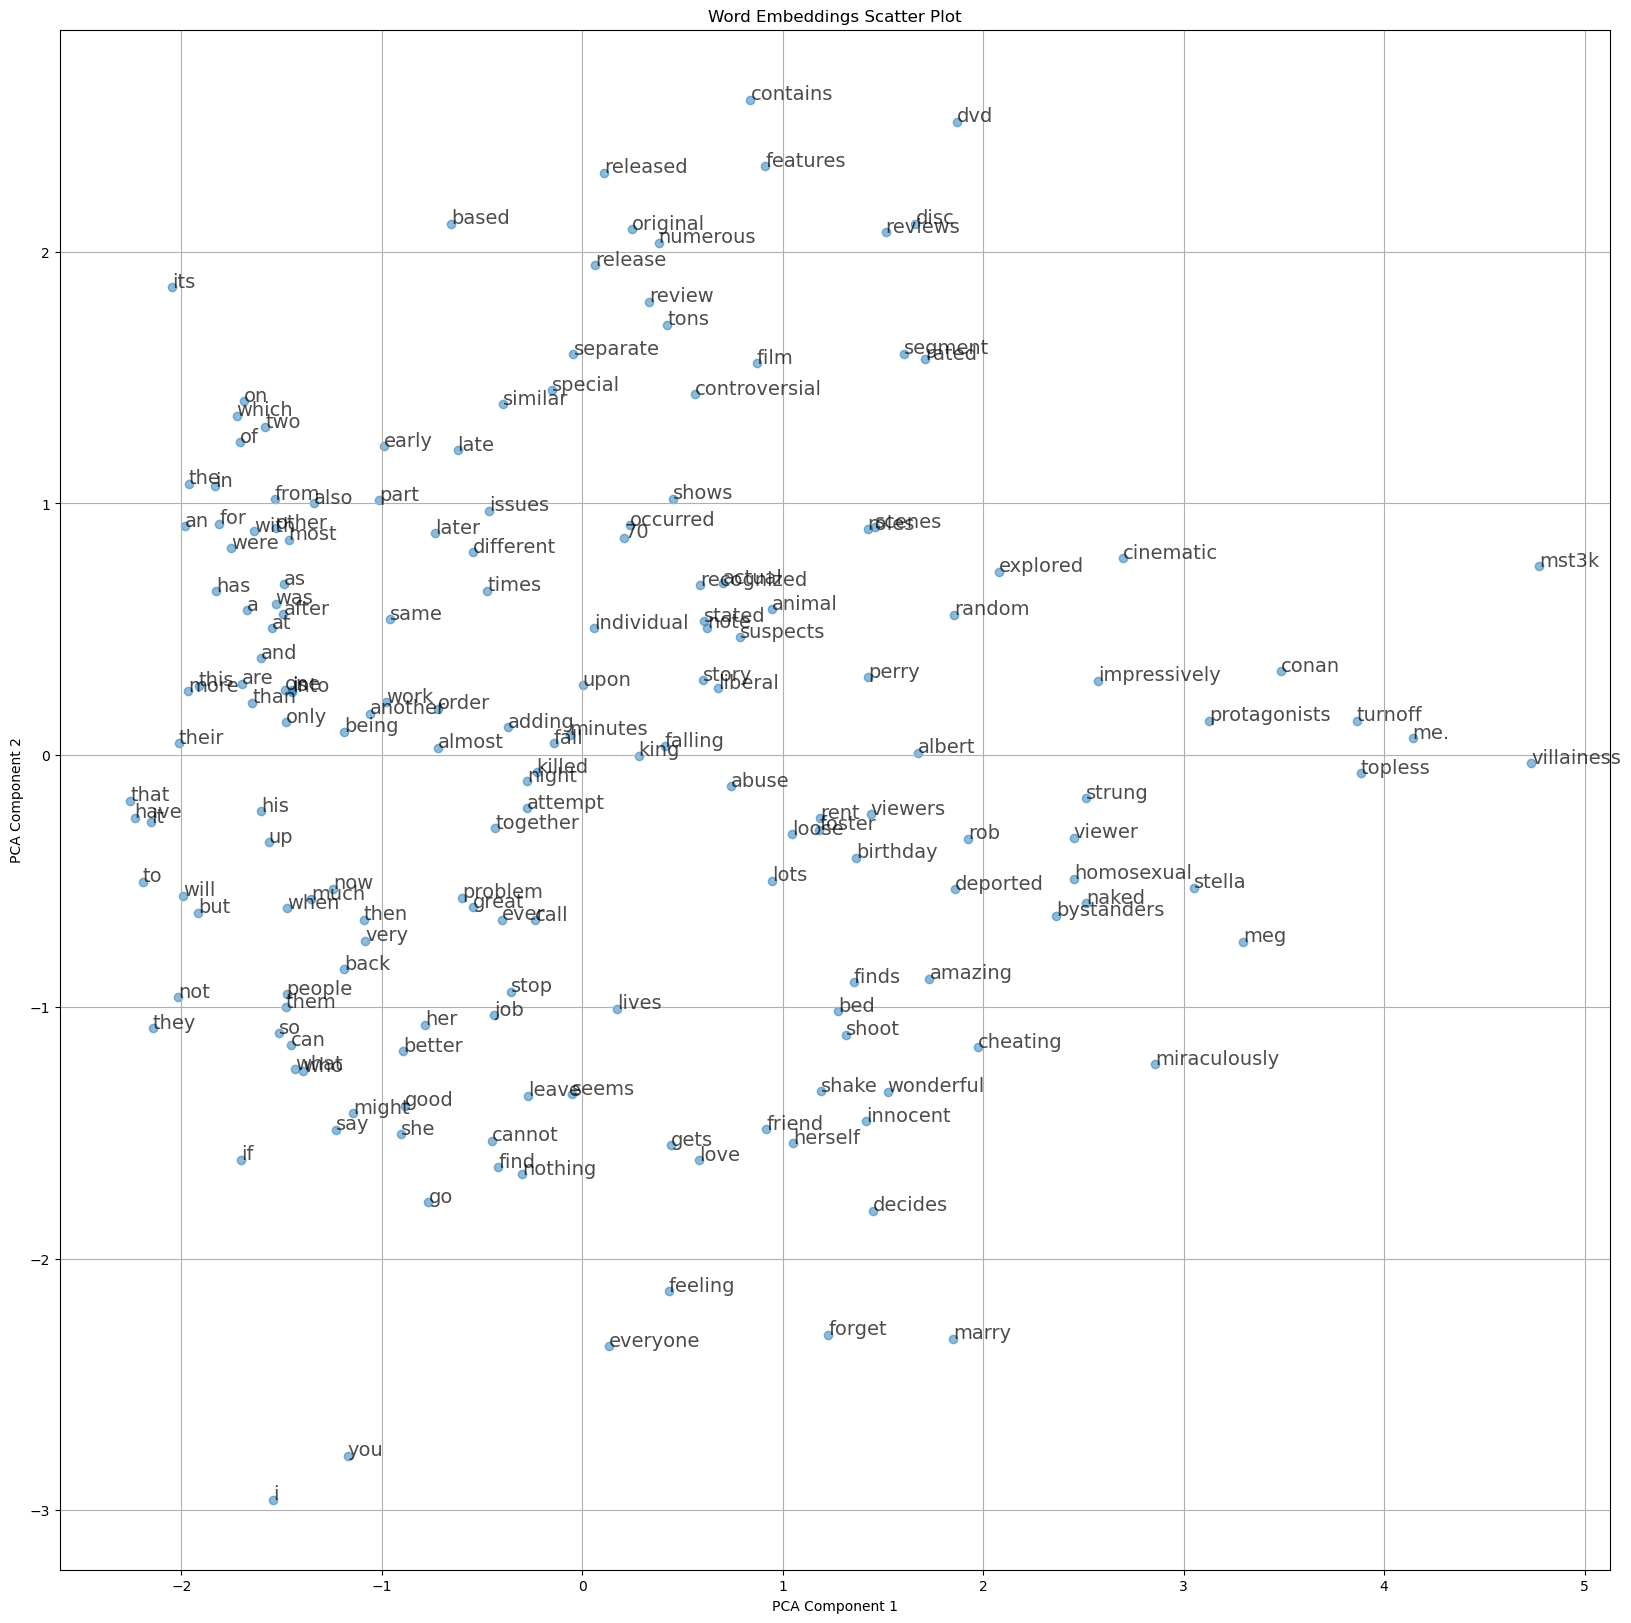

In [11]:

# Extracting x and y coordinates and corresponding words
x_coords = [val_pca_words[word][0] for word in val_pca_words]
y_coords = [val_pca_words[word][1] for word in val_pca_words]
words = list(val_pca_words.keys())

# Creating the scatter plot
plt.figure(figsize=(20, 20))
plt.scatter(x_coords, y_coords, alpha=0.5)

# Annotating the words
for i, word in enumerate(words):
    plt.annotate(word, (x_coords[i], y_coords[i]), fontsize=14, alpha=0.7)

plt.title("Word Embeddings Scatter Plot")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()

# TODO: Write the semantic clustering in the answer
# The articles are clustered in the left portion of the plot along with common helping-verbs like was, is, are, etc.
# The adjective words are clustered in the right portion of the plot. The words like "wonderful", "innocent", "forget" are clustered together.
# Pronouns I and you are clustered together. at the bottom left 
# The words like "movie", "film", "story" are clustered together.

## Creating features from word to vec for the second part

In [12]:
# Function that creates a sentence representation words not in glove are dropped.
def create_sentence_representation(sentence,glove_vectors):
    sentence_representation = []
    sentence = sentence.lower()
    for word in sentence.split():
        if word in glove_vectors:
            sentence_representation.append(glove_vectors[word])
    return sentence_representation

In [13]:
X_train = [torch.tensor(np.array(create_sentence_representation(sentence,glove_vectors))) for sentence in df_train['review']]
X_val = [torch.tensor(np.array(create_sentence_representation(sentence,glove_vectors))) for sentence in df_val['review']]
X_test = [torch.tensor(np.array(create_sentence_representation(sentence,glove_vectors))) for sentence in df_test['review']]
y_train = df_train['sentiment'].values
y_val = df_val['sentiment'].values
y_test = df_test['sentiment'].values

# Part b

## TODO : Mention the initial Learning rate in the report

## Creating a dataloader

In [14]:
from torch.nn.utils.rnn import pad_sequence
def my_collate(batch):
    len_list = []
    x_list = []
    y_list = []
    for x,y in batch:
        len_list.append(x.shape[0])
        x_list.append(x)
        y_list.append(y)
    x_list = pad_sequence(x_list,batch_first=True) # batch,max_seq_len,100
    y_list = torch.tensor(y_list)
    len_list = torch.tensor(len_list)
    return x_list,y_list.float(),len_list


In [15]:
def create_dataloder(X,y,batch_size):
    dataset = list(zip(X,y))
    dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=True,collate_fn=my_collate)
    return dataloader

In [16]:
batch_size = 32

In [17]:
train_dl = create_dataloder(X_train,y_train,batch_size)
val_dl = create_dataloder(X_val,y_val,batch_size)
test_dl = create_dataloder(X_test,y_test,batch_size)

## Creating and Training LSTM Model

In [ ]:
class lstm_model_avg_pool(nn.Module):
    def __init__(self,hidden_size=256,num_layers=2):
        super().__init__()
        self.classifier = nn.Linear(hidden_size,1)
        self.lstm = nn.LSTM(100,hidden_size,num_layers,batch_first=True)
    
    def make_mask(self,len_list,device):
        batch_size = len_list.shape[0]
        max_len = len_list.max()
        mask = len_list.reshape(batch_size,1) > torch.arange(max_len).reshape(1,max_len).to(device) # batch,max_len
        return mask.reshape(batch_size,max_len,1)
    def forward(self,x,len_list,device):
        '''
        len_list : batch to be used to make a mask
        '''
        out,_ = self.lstm(x) #  batch,seq_len,hidde_size
        mask = self.make_mask(len_list,device)
        out = out*mask # batch,seq_len,hidden_size
        out_pool = out.sum(dim=1)/len_list.reshape(-1,1) # batch,hidden_size
        return self.classifier(out_pool) # batch,1

In [18]:
# An abstract class that will be used to train the models inspired from the assignments of NLP course
class ModelTrainer:
    def __init__(self,model,train_dl,val_dl,optimizer=None,batch_size=32,epochs=25):
        self.model = model
        if optimizer is None:
            self.optimizer = optim.Adam(model.parameters(),lr=1e-3)
        else:
            self.optimizer = optimizer
        self.criterion = nn.BCEWithLogitsLoss()
        self.epochs = epochs
        self.train_loss = {}
        self.val_loss = {}
        self.batch_size = batch_size
        self.train_dl = train_dl
        self.val_dl = val_dl
        self.steps = 0
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
    def train(self):
        self.train_loss[0] = self.get_validation_loss(self.train_dl)
        self.val_loss[0] = self.get_validation_loss(self.val_dl)
        tqdm.write(f'Epoch : 0 Train Loss : {self.train_loss[0]} Validation Loss : {self.val_loss[0]}')
        for epoch in tqdm(range(1,self.epochs+1)):
                for xb,yb,len_list in train_dl:
                    self.model.train()
                    self.optimizer.zero_grad()
                    xb,yb,len_list = xb.to(self.device),yb.to(self.device),len_list.to(self.device)
                    y_pred = self.model(xb,len_list,self.device)
                    loss = self.criterion(y_pred,yb.unsqueeze(1))
                    loss.backward()
                    self.optimizer.step()
                    self.steps += 1
                self.train_loss[epoch] = self.get_validation_loss(self.train_dl)
                self.val_loss[epoch] = self.get_validation_loss(self.val_dl)
                tqdm.write(f'Epoch : {epoch} Train Loss : {self.train_loss[epoch]} Validation Loss : {self.val_loss[epoch]}')                    
                
    def get_validation_loss(self,set_dl):
        self.model.eval()
        val_dl = set_dl
        with torch.no_grad():
            val_loss = 0
            total_len = 0
            for xb,yb,len_list in val_dl:
                xb,yb,len_list = xb.to(self.device),yb.to(self.device),len_list.to(self.device)
                y_pred = self.model(xb,len_list,self.device)
                loss = self.criterion(y_pred,yb.unsqueeze(1))
                val_loss += loss.item()*len(yb)
                total_len += len(yb)
            return val_loss/total_len
        
    def plot_losses(self,title_str):
        plt.plot(list(self.train_loss.keys()),list(self.train_loss.values()),label='Train Loss',marker='*')
        plt.plot(list(self.val_loss.keys()),list(self.val_loss.values()),label='Validation Loss',marker='o')
        plt.title(title_str)
        plt.xlabel('Number of Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig(title_str+'.png')
        plt.show()
    
    def get_test_accuracy(self,test_dl):
        self.model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for xb,yb,len_list in test_dl:
                xb,yb,len_list = xb.to(self.device),yb.to(self.device),len_list.to(self.device)
                y_pred = self.model.forward(xb,len_list,self.device)
                y_pred = torch.where(y_pred>0,1,0)
                correct += (y_pred == yb.unsqueeze(1)).sum().item()
                total += yb.shape[0]
            return correct/total

In [ ]:
lstm_model_avg_pool_obj = lstm_model_avg_pool()
model_trainer = ModelTrainer(lstm_model_avg_pool_obj,train_dl=train_dl,val_dl=val_dl)
model_trainer.train()

In [ ]:
print(f"Train Accuracy lstm avg pool: {model_trainer.get_test_accuracy(train_dl)}")
print(f"Validation Accuracy lstm avg pool: {model_trainer.get_test_accuracy(val_dl)}")
print(f"Test Accuracy lstm avg pool: {model_trainer.get_test_accuracy(test_dl)}")
model_trainer.plot_losses('Train and Validation Losses LSTM Avg Pool')
del(lstm_model_avg_pool_obj)
del(model_trainer)

# Part c

## Creating and training a attention based pooling model

In [ ]:
class lstm_model_attention(nn.Module):
    def __init__(self,hidden_size=256,num_layers=2):
        super().__init__()
        self.classifier = nn.Linear(hidden_size,1)
        self.lstm = nn.LSTM(100,hidden_size,num_layers,batch_first=True)
        self.V = nn.Linear(hidden_size,1)
        self.W = nn.Linear(hidden_size,hidden_size)
    def attention(self,out):
        '''
        out : batch,max_seq_len,hidden_size
        Implements attention socres as v.Tanh(W*out+b)
        '''
        unnorm_attn_scores = self.V(torch.tanh(self.W(out)))
        return unnorm_attn_scores # batch,max_seq_len,1
    def make_mask(self,len_list,device):
        batch_size = len_list.shape[0]
        max_len = len_list.max()
        mask = len_list.reshape(batch_size,1) > torch.arange(max_len).reshape(1,max_len).to(device) # batch,max_len
        return mask.reshape(batch_size,max_len,1)
            
    def forward(self,x,len_list,device):
        out,_ = self.lstm(x) # batch,max_seq_len,hidde_size
        unnorm_scores = self.attention(out) # batch,max_seq_len,1
        mask = self.make_mask(len_list,device)
        attn_scores = torch.where(mask,unnorm_scores,-float('inf')) # batch,max_seq_len,1
        attn_scores = torch.softmax(attn_scores,dim=1).reshape(-1,1,len_list.max()) # batch,1,max_seq_len
        out_context = attn_scores@out # batch,1,hidden_size
        final_out = self.classifier(out_context).reshape(-1,1) # batch,1
        return final_out

In [ ]:
lst_model_attention_obj = lstm_model_attention()
model_trainer = ModelTrainer(lst_model_attention_obj,train_dl=train_dl,val_dl=val_dl)
model_trainer.train()

In [ ]:
print(f"Train Accuracy lstm avg pool: {model_trainer.get_test_accuracy(train_dl)}")
print(f"Validation Accuracy lstm avg pool: {model_trainer.get_test_accuracy(val_dl)}")
print(f"Test Accuracy lstm avg pool: {model_trainer.get_test_accuracy(test_dl)}")
model_trainer.plot_losses('Train and Validation Losses LSTM Attention')
del(lst_model_attention_obj)
del(model_trainer)
#TODO: Write that tanh attention is used in the answer

# Part d

## Implementing and training a transformer encoder block

In [ ]:
class transformer_encoder_model(nn.Module):
    def __init__(self,hidden_size=256):
        super().__init__()
        self.classifier = nn.Linear(hidden_size,1)
        self.Q = nn.Linear(100,hidden_size,bias=False)
        self.K = nn.Linear(100,hidden_size,bias=False)
        self.V = nn.Linear(100,hidden_size,bias=False)
        self.layern_norm1 = nn.LayerNorm(hidden_size)
        self.fnn1a = nn.Linear(hidden_size,hidden_size)
        self.fnn1b = nn.Linear(hidden_size,hidden_size)
        self.layern_norm2 = nn.LayerNorm(hidden_size)
    def make_mask(self,len_list,device):
        batch_size = len_list.shape[0]
        max_len = len_list.max()
        mask = len_list.reshape(batch_size,1) > torch.arange(max_len).reshape(1,max_len).to(device) # batch,max_len
        return mask.reshape(batch_size,max_len,1)


    def forward(self,x,len_list,device):
        query= self.Q(x) # batch,max_seq_len,hidden_size
        key = self.K(x) 
        vals = self.V(x)
        mask = self.make_mask(len_list,device)
        attn_scores = query@key.transpose(1,2) # batch,max_seq_len,max_seq_len
        scaled_attn_scores = attn_scores/np.sqrt(query.shape[-1]) # batch,max_seq_len,max_seq_len
        masked_attn_scores = torch.where(mask.reshape(mask.shape[0],1,-1),scaled_attn_scores,-float('inf'))
        normalized_attn_scores = torch.softmax(masked_attn_scores,dim=2)
        out = normalized_attn_scores@vals # batch,max_seq_len,hidden_size
        out_masked = out*mask   # batch,max_seq_len,hidden_size
        out_masked = self.layern_norm1(out_masked)  # batch,max_seq_len,hidden_size
        out_masked = self.fnn1b(torch.relu(self.fnn1a(out_masked))) # batch,max_seq_len,hidden_size
        out_masked = self.layern_norm2(out_masked + out) 
        out_masked_comb = out_masked*mask
        out_masked_comb = out_masked_comb.sum(dim=1)/len_list.reshape(-1,1)
        return self.classifier(out_masked_comb) # batch,1

In [22]:
transformer_encoder_model_obj = transformer_encoder_model()
model_trainer = ModelTrainer(transformer_encoder_model_obj,train_dl=train_dl,val_dl=val_dl)
model_trainer.train()

Epoch : 0 Train Loss : 0.7061147231578827 Validation Loss : 0.7072918493270874


  4%|▍         | 1/25 [05:13<2:05:32, 313.86s/it]

Epoch : 1 Train Loss : 0.4738870867371559 Validation Loss : 0.48887598400115967


  8%|▊         | 2/25 [10:36<2:02:17, 319.02s/it]

Epoch : 2 Train Loss : 0.37314380155801774 Validation Loss : 0.38665821695327757


 12%|█▏        | 3/25 [15:57<1:57:19, 320.00s/it]

Epoch : 3 Train Loss : 0.35076648570895197 Validation Loss : 0.37150550785064695


 16%|█▌        | 4/25 [21:18<1:52:04, 320.20s/it]

Epoch : 4 Train Loss : 0.34843523408174515 Validation Loss : 0.3657206438541412


 20%|██        | 5/25 [26:38<1:46:46, 320.34s/it]

Epoch : 5 Train Loss : 0.3459193491876125 Validation Loss : 0.37541403951644897


 24%|██▍       | 6/25 [32:00<1:41:33, 320.69s/it]

Epoch : 6 Train Loss : 0.3256735220253468 Validation Loss : 0.3667877511978149


 28%|██▊       | 7/25 [37:14<1:35:33, 318.53s/it]

Epoch : 7 Train Loss : 0.3134909150421619 Validation Loss : 0.35132765169143676


 32%|███▏      | 8/25 [42:40<1:30:56, 320.96s/it]

Epoch : 8 Train Loss : 0.3087899928867817 Validation Loss : 0.35278701887130737


 36%|███▌      | 9/25 [49:25<1:32:36, 347.28s/it]

Epoch : 9 Train Loss : 0.32687489346861837 Validation Loss : 0.37011442456245425


 40%|████      | 10/25 [57:03<1:35:20, 381.37s/it]

Epoch : 10 Train Loss : 0.30290181381702425 Validation Loss : 0.3465485755681992


 44%|████▍     | 11/25 [1:02:08<1:23:34, 358.21s/it]

Epoch : 11 Train Loss : 0.2915572555243969 Validation Loss : 0.3485628647327423


 48%|████▊     | 12/25 [1:07:18<1:14:24, 343.44s/it]

Epoch : 12 Train Loss : 0.3129627437889576 Validation Loss : 0.3677943223953247


 52%|█████▏    | 13/25 [1:12:23<1:06:20, 331.70s/it]

Epoch : 13 Train Loss : 0.2879299170672894 Validation Loss : 0.35448175187110903


 56%|█████▌    | 14/25 [1:17:26<59:15, 323.20s/it]  

Epoch : 14 Train Loss : 0.2713508072376251 Validation Loss : 0.339424338054657


 60%|██████    | 15/25 [1:22:33<53:01, 318.12s/it]

Epoch : 15 Train Loss : 0.2586863552391529 Validation Loss : 0.3429670791149139


 64%|██████▍   | 16/25 [1:27:37<47:04, 313.88s/it]

Epoch : 16 Train Loss : 0.2722655674755573 Validation Loss : 0.3627022267818451


 68%|██████▊   | 17/25 [1:32:42<41:31, 311.38s/it]

Epoch : 17 Train Loss : 0.2546493074506521 Validation Loss : 0.3419135920524597


 72%|███████▏  | 18/25 [1:37:54<36:20, 311.44s/it]

Epoch : 18 Train Loss : 0.2527313051342964 Validation Loss : 0.34141202845573426


 76%|███████▌  | 19/25 [1:42:58<30:54, 309.13s/it]

Epoch : 19 Train Loss : 0.24725390022993088 Validation Loss : 0.35833811955451966


 80%|████████  | 20/25 [1:48:04<25:41, 308.34s/it]

Epoch : 20 Train Loss : 0.24508481938838958 Validation Loss : 0.34770006475448606


 84%|████████▍ | 21/25 [1:53:11<20:31, 307.90s/it]

Epoch : 21 Train Loss : 0.23974199875593186 Validation Loss : 0.3633719150841236


 88%|████████▊ | 22/25 [1:58:15<15:19, 306.61s/it]

Epoch : 22 Train Loss : 0.23054721191227437 Validation Loss : 0.3549626965999603


 92%|█████████▏| 23/25 [2:05:24<11:26, 343.35s/it]

Epoch : 23 Train Loss : 0.23470788856744768 Validation Loss : 0.3377522539317608


 96%|█████████▌| 24/25 [2:12:11<06:02, 362.69s/it]

Epoch : 24 Train Loss : 0.2238890386670828 Validation Loss : 0.36479247879981996


100%|██████████| 25/25 [2:21:06<00:00, 338.66s/it]

Epoch : 25 Train Loss : 0.23894551050066948 Validation Loss : 0.39200957481861115


Train Accuracy lstm avg pool: 0.9012
Validation Accuracy lstm avg pool: 0.8456
Test Accuracy lstm avg pool: 0.8534


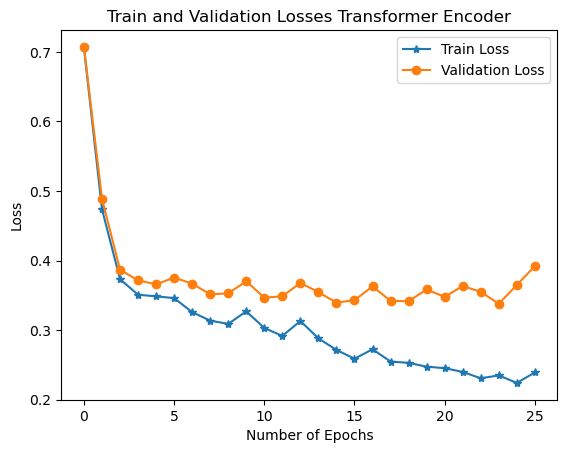

In [23]:
print(f"Train Accuracy lstm avg pool: {model_trainer.get_test_accuracy(train_dl)}")
print(f"Validation Accuracy lstm avg pool: {model_trainer.get_test_accuracy(val_dl)}")
print(f"Test Accuracy lstm avg pool: {model_trainer.get_test_accuracy(test_dl)}")
model_trainer.plot_losses('Train and Validation Losses Transformer Encoder')